Author Classification
===

Notebook to build models for the author classification problem.

Current classification approach uses Vowpal Wabbit. Future approaches could try using sklearn or more sophisticated approaches if necessary.  (One could for example a PyStruct i.e. structured prediction model.)

In [1]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import sklearn
from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle

import Levenshtein  # for computing edit distance

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [68]:
general_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification"
vw_working_dir = os.path.join(general_working_dir, "vw")
os.makedirs(vw_working_dir, exist_ok=True)

In [3]:
use_cached_results = False  # set to true to load cached intermediate results from pickle rather than redoing the computations

# Caching option specifically for instrumental support, since that's more intensive computationally
use_cached_instrumental_support_results = True

# Whether or not to write to the cbAnnotator database (which has caused desync issues in the past)
skip_prediction_insertion = True

In [4]:
def get_db():
    journal_wd="/home/srivbane/shared/caringbridge/data/derived/sqlite"
    db_filename = os.path.join(journal_wd, "journal.db")
    db = sqlite3.connect(
            db_filename,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_journal_text(site_id, journal_oid):
    site_id = int(site_id)
    
    # add journal text as new section
    try:
        db = get_db()
        cursor = db.execute("""SELECT body
                                FROM journal 
                                WHERE site_id = ? AND journal_oid = ?""", 
                            (site_id, journal_oid))
        body = cursor.fetchone()
        assert body is not None
        body_text = body['body']
        if body_text is None:
            body_text = ""
        return body_text
    finally:
        db.close()
        
def get_journal_texts(site_id):
    site_id = int(site_id)
    
    texts = []
    try:
        db = get_db()
        cursor = db.execute("""SELECT journal_oid, body
                                FROM journal 
                                WHERE site_id = ?""", 
                            (site_id,))
        results = cursor.fetchall()
        assert results is not None
        for result in results:
            body_text = result['body']
            if body_text is None:
                body_text = ""
            journal_oid = result['journal_oid']
            texts.append({
                'journal_oid': journal_oid,
                'body': body_text
            })
        return texts
    finally:
        db.close()

In [5]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html_text):
    s = MLStripper()
    s.feed(html_text)
    return s.get_data()


def get_cleaned_text_from_token_list(token_list):
    cleaned_text = " ".join(token_list).replace(':', 'COLON').replace('|', 'PIPE').replace("\n", "NEWLINE ")
    return cleaned_text

def get_cleaned_text(text):
    stripped = strip_tags(text)
    tokens = word_tokenize(stripped)
    tokens = [token.lower() for token in tokens]
    cleaned_text = get_cleaned_text_from_token_list(tokens)
    return cleaned_text

### Load annotation client author types

In [6]:
annotation_web_client_database = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/cbAnnotator.sqlite"


def get_annotation_db():
    db = sqlite3.connect(
            annotation_web_client_database,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_author_annotations():
    try:
        db = get_annotation_db()
        cursor = db.execute(
            """SELECT site_id, journal_oid, data 
                FROM journalAnnotation
                WHERE annotation_type = "journal_author_type" AND username = "levon003"
                GROUP BY site_id, journal_oid
                ORDER BY id DESC""")  # FIXME Currently, we pull only my own authorship tags
        journal_author_annotations = cursor.fetchall()
        annotation_strings = [{'site_id': a['site_id'], 
                               'journal_oid': a['journal_oid'], 
                               'data': a['data']}
                              for a in journal_author_annotations]
        return annotation_strings
    finally:
        db.close()


# Test extraction of annotations
get_author_annotations()[:10]

[{'site_id': 193755, 'journal_oid': '51c060cb6ca00467161ab1d5', 'data': 'p'},
 {'site_id': 193755, 'journal_oid': '51c060cb6ca00467161ab165', 'data': 'p'},
 {'site_id': 147458, 'journal_oid': '51be1f556ca0045458010938', 'data': 'p'},
 {'site_id': 200461, 'journal_oid': '51be2c476ca004ec020111c6', 'data': 'p'},
 {'site_id': 200461, 'journal_oid': '51be2c476ca004ec02010b28', 'data': 'p'},
 {'site_id': 200461, 'journal_oid': '51be2c476ca004ec02010a88', 'data': 'cg'},
 {'site_id': 200461, 'journal_oid': '51be2c476ca004ec020111b8', 'data': 'p'},
 {'site_id': 540483, 'journal_oid': '51be57ed6ca0048015002c8d', 'data': 'p'},
 {'site_id': 540483, 'journal_oid': '51be57ed6ca0048015002c75', 'data': 'p'},
 {'site_id': 857640, 'journal_oid': '5318bdb6a689b4ce0823fe51', 'data': 'cg'}]

In [7]:
web_client_annotations_raw = get_author_annotations()
Counter([a['data'] for a in web_client_annotations_raw]).most_common()

[('p', 311), ('cg', 253), ('unk', 29), ('pcg', 4)]

In [8]:
web_client_annotation_list = []

for annotation in tqdm(web_client_annotations_raw):
    site_id = annotation['site_id']
    journal_oid = annotation['journal_oid']
    body = get_journal_text(site_id, journal_oid)
    if len(body) < 50:
        continue
        
    label = annotation['data']
    # One consideration: do we want to include unknown journals in the training data?
    #if label == "unk":
    #    continue
        
    cleaned_body = get_cleaned_text(body)
    
    annotation_dict = {
        "site_id": annotation['site_id'],
        "journal_oid": annotation['journal_oid'], 
        "cleaned_body": cleaned_body,
        "label": label
    }
    web_client_annotation_list.append(annotation_dict)

len(web_client_annotation_list)

100%|██████████| 597/597 [00:16<00:00, 36.58it/s]


578

In [9]:
web_client_annotation_list_pickle_filepath = os.path.join(vw_working_dir, "web_client_annotations.pkl")

if use_cached_results and os.path.exists(web_client_annotation_list_pickle_filepath):
    with open(web_client_annotation_list_pickle_filepath, 'rb') as f:
        web_client_annotation_list = pickle.load(f)
else:  # should save the processed list
    with open(web_client_annotation_list_pickle_filepath, 'wb') as f:
        pickle.dump(web_client_annotation_list, f)
print("Finished.")

Finished.


### Load instrumental support coding author types

In [10]:
appreciation_coding_filepath = "/home/srivbane/levon003/repos/instrumental_support/appreciation_coding/collect_coding_results/certain_data/all_certain_data.csv"
df = pd.read_csv(appreciation_coding_filepath)
len(df)

732

In [11]:
Counter(df['author_type']).most_common()

[('C', 427), ('P', 292), ('PC', 13)]

In [12]:
instrumental_support_annotation_list = []
skipped = 0
if not use_cached_instrumental_support_results:
    try:
        db = get_db()
        for i in tqdm(range(len(df))):
            row = df.iloc[i]
            site_id = int(row['site_id'])

            if len(row['body_text']) < 50:
                continue
            comparison_body = row['body_text'][:500].lower()

            cursor = db.execute("""SELECT site_id, journal_oid, title, body
                                    FROM journal
                                    WHERE site_id = ?
                                    GROUP BY site_id, journal_oid
                                    ORDER BY createdAt""",
                                (site_id,))
            current_match = None
            for res in cursor.fetchall():
                if res['body'] is None or len(res['body']) < 50:
                    continue
                title = get_cleaned_text(res['title']) if res['title'] is not None else ""
                body = get_cleaned_text(res['body'][:500-len(title)-1]).lower()

                title_and_body = title + " " + body
                distance = Levenshtein.distance(title_and_body, comparison_body)

                if current_match is None or current_match['distance'] >= distance:
                    #if current_match is not None and current_match['distance'] == distance:
                    #    print("Warning: Equivalent match found in site %d." % site_id)
                    #    print("  Old match text:", current_match['title_body'][:200])
                    #    print("  New match text:", title_and_body[:200])
                    current_match = {
                        "journal_oid": res['journal_oid'],
                        "title_body": title_and_body[:300],
                        "body": get_cleaned_text(res['body']),
                        "distance": distance
                    }
                    if distance <= 4:  # just assume that this is an exact match; no need to look at the other journals
                        break
            # print out particularly large differences for manual inspection
            if current_match['distance'] > 220:
                print(site_id, current_match['journal_oid'], current_match['distance'])
                print("Matched Journal:", current_match['title_body'][:200])
                print("Dataframe Input:", comparison_body[:200])
                skipped += 1
                continue  # discard this record, not including it in the list of annotations.

            match_dict = {
                "site_id": site_id,
                "journal_oid": current_match['journal_oid'], 
                "cleaned_body": current_match['body'],
                "label": row['author_type']
            }
            instrumental_support_annotation_list.append(match_dict)
    finally:
        db.close()
    
len(instrumental_support_annotation_list), skipped  # Note: 10 or so records are skipped during computation due to bad matches

(0, 0)

In [13]:
instrumental_support_annotation_list_pickle_filepath = os.path.join(vw_working_dir, "instrumental_support_annotations.pkl")

if (use_cached_results or use_cached_instrumental_support_results) and os.path.exists(instrumental_support_annotation_list_pickle_filepath):
    with open(instrumental_support_annotation_list_pickle_filepath, 'rb') as f:
        instrumental_support_annotation_list = pickle.load(f)
else:  # should save the processed list
    with open(instrumental_support_annotation_list_pickle_filepath, 'wb') as f:
        pickle.dump(instrumental_support_annotation_list, f)
print("Finished.")

Finished.


### Merge the annotation sources into a common format

In [14]:
annotations = web_client_annotation_list[:]
for instr_annotation in instrumental_support_annotation_list:
    annotation_already_present = False
    for web_annotation in web_client_annotation_list:
        if instr_annotation['site_id'] == web_annotation['site_id'] \
            and instr_annotation['journal_oid'] == web_annotation['journal_oid']:
                annotation_already_present = True
                print("Duplicate:", instr_annotation['label'], web_annotation['label'])
    if not annotation_already_present:
        annotations.append(instr_annotation)
len(annotations)

Duplicate: C cg
Duplicate: P p
Duplicate: P p
Duplicate: C cg
Duplicate: C cg
Duplicate: P p
Duplicate: P p


1293

### Convert to Vowpal Wabbit line format

In [ ]:
lines = []
for annotation in annotations:
    label_section = "-1"
    if annotation['label'] in ["p", "P"]:
        label_section = "+1"
    
    identifier = "sid%djoid%s" % (annotation['site_id'], annotation['journal_oid'])
    
    formatted_journal = label_section + " " + identifier + "|J " + annotation['cleaned_body']
    lines.append(formatted_journal)

lines[:2]

In [16]:
train_lines = []
valid_lines = []

holdout_percent = 0.2
holdout_start_index = len(lines) - int(len(lines) * holdout_percent)

train_lines = lines[:holdout_start_index]
valid_lines = lines[holdout_start_index:]

for i, annotation in enumerate(annotations):
    annotation['in_training_data'] = i < holdout_start_index

len(train_lines), len(valid_lines)

(1035, 258)

In [17]:
# write the formatted lines to a file (after another shuffle)
random.shuffle(train_lines)
random.shuffle(valid_lines)

vw_filename = "author_journal_text_only.txt"
vw_filepath = os.path.join(vw_working_dir, vw_filename)
with open(vw_filepath, 'w', encoding="utf-8") as outfile:
    for line in train_lines:
        outfile.write(line + "\n")
    for line in valid_lines:
        outfile.write(line + "\n")
holdout_after = len(train_lines)
print("Finished writing VW-formatted file.")

Finished writing VW-formatted file.


In [ ]:
!head -n 1 {vw_filepath}

### Train the VW model on the training data

In [19]:
%%bash -s {vw_working_dir} {vw_filepath} {holdout_after}
holdout_after="${3}"
echo "Training on training set (holdout after ${holdout_after} lines)."
train_file=${2}
working_dir=${1}
model_file=${working_dir}
vw --binary -k -c -b 27 -d ${train_file} \
    -f ${working_dir}/patient_authored.model \
    --passes 20 \
    --holdout_after ${holdout_after} \
    --spelling _ \
    --ngram 3 \
    --l2 0.000001 \
    --loss_function logistic

# Other options:
#    --skips 1 \
>&2 echo
>&2 echo

echo "Making predictions."
vw --binary \
   -t -i ${working_dir}/patient_authored.model \
   -p ${working_dir}/author_journal_text_only.pred \
   -d ${train_file} \
   -r ${working_dir}/author_journal_text_only.pred.raw

#echo "Predicting on test set."
#vw -t -i data/site_features_multiclass.model -d wd/site_features_multiclass_test.txt -p data/site_features_multiclass_test.pred
#echo
 
echo "Finished."

Training on training set (holdout after 1035 lines).
Making predictions.
Finished.


Generating 3-grams for all namespaces.
using l2 regularization = 1e-06
final_regressor = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/patient_authored.model
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.txt.cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000     1684
0.500000 0.000000            2            2.0   1.0000   1.0000     4390
0.750000 1.000000            4            4.0   1.0000  -1.0000      910
0.625000 0.500000       

In [20]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred

1 sid912454joid5470dee0ca16b4c27bb0e9a5
1 sid999165joid54faf55eaf3d799c34ab808e
-1 sid837521joid54009962a589b4154824af37
1 sid1031202joid562b9247cb16b4f264752816
-1 sid867022joid55b61016ac7ee9534a13386c


In [21]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred.raw

7.854739 sid912454joid5470dee0ca16b4c27bb0e9a5
10.844439 sid999165joid54faf55eaf3d799c34ab808e
-8.962088 sid837521joid54009962a589b4154824af37
4.933350 sid1031202joid562b9247cb16b4f264752816
-3.771698 sid867022joid55b61016ac7ee9534a13386c


### Load the predictions made by VW on the training/validation data as a Pandas dataframe

In [22]:
def get_phase_predictions_with_weights(pred_filepath, raw_pred_filepath):
    
    with open(pred_filepath, 'r') as infile:
        pred_lines = infile.readlines()
    with open(raw_pred_filepath, 'r') as infile:
        raw_pred_lines = infile.readlines()
        
    if len(pred_lines) != len(raw_pred_lines):
        raise ValueError("Expected predicted and raw files to be the same length.")
    
    dtype_dict = {"site_id": int, 
                     "journal_oid": str,
                     "raw_prob": float,
                     "prob": float,
                     "is_patient": bool,
                     "is_patient_predicted": bool,
                     "in_training_data": bool}
    columns = list(dtype_dict.keys())
    dtype = [dtype_dict[col] for col in columns]
    pred_df = pd.DataFrame(index=range(len(pred_lines)), columns=columns)
    
    index = 0
    for pred_line, raw_pred_line in zip(pred_lines, raw_pred_lines):
        prediction, journal_id = pred_line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        
        pred_df.iloc[index]["site_id"] = site_id
        pred_df.iloc[index]["journal_oid"] = journal_oid
        pred_df.iloc[index]["is_patient_predicted"] = prediction == "1"
        for annotation in annotations:
            if annotation['site_id'] == site_id and annotation['journal_oid'] == journal_oid:
                pred_df.iloc[index]["is_patient"] = annotation['label'] in ["p", "P"]
                pred_df.iloc[index]["in_training_data"] = annotation["in_training_data"]
        
        raw_prob, raw_journal_id = raw_pred_line.strip().split(" ")
        assert journal_id == raw_journal_id
        pred_df.iloc[index]["raw_prob"] = float(raw_prob)
        # if using a logistic loss function, we can recover the "probability" by applying the logistic function
        pred_df.iloc[index]["prob"] = 1 / (1 + np.exp(-1 * float(raw_prob) ))
        
        index += 1
    return pred_df

In [23]:
pred_df = get_phase_predictions_with_weights("/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred",
                                  "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred.raw")

print(pred_df.dtypes)  # datatypes just stay object for now...
pred_df.head()

site_id                 object
journal_oid             object
raw_prob                object
prob                    object
is_patient              object
is_patient_predicted    object
in_training_data        object
dtype: object


,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data
0,912454,5470dee0ca16b4c27bb0e9a5,7.85474,0.999612,True,True,True
1,999165,54faf55eaf3d799c34ab808e,10.8444,0.99998,True,True,True
2,837521,54009962a589b4154824af37,-8.96209,0.000128162,False,False,True
3,1031202,562b9247cb16b4f264752816,4.93335,0.992849,True,True,True
4,867022,55b61016ac7ee9534a13386c,-3.7717,0.0224953,False,False,True


In [24]:
def get_url(site_id, journal_oid, port=5000):
    url = "http://127.0.0.1:%d/siteId/%d#%s" % (port, site_id, journal_oid)
    return '<a href="{}">{}</a>'.format(url, url)

pd.set_option('display.max_colwidth', -1)  # allow the entirety of the url to show by removing column width limits

pred_df['annotation_url'] = [get_url(pred_df.iloc[i]['site_id'], pred_df.iloc[i]['journal_oid']) for i in range(len(pred_df))]
pred_df.head(n=1)

,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data,annotation_url
0,912454,5470dee0ca16b4c27bb0e9a5,7.85474,0.999612,True,True,True,"<a href=""http://127.0.0.1:5000/siteId/912454#5470dee0ca16b4c27bb0e9a5"">http://127.0.0.1:5000/siteId/912454#5470dee0ca16b4c27bb0e9a5</a>"


### Pull out the training and validation data and analyze accuracy

In [25]:
train_df = pred_df[pred_df["in_training_data"] == True]
assert len(train_df) == len(train_lines)

In [26]:
valid_df = pred_df[pred_df["in_training_data"] == False]
assert len(valid_df) == len(valid_lines)

In [27]:
# Train accuracy
np.sum(train_df["is_patient_predicted"] == train_df["is_patient"]) / len(train_df)

0.9980676328502416

In [28]:
# Validation accuracy
np.sum(valid_df["is_patient_predicted"] == valid_df["is_patient"]) / len(valid_df)

0.9263565891472868

In [29]:
Counter(valid_df["is_patient_predicted"]).most_common()

[(False, 162), (True, 96)]

In [30]:
Counter(valid_df["is_patient"]).most_common()

[(False, 163), (True, 95)]

In [31]:
y_true = [1 if b else 0 for b in valid_df["is_patient"]]
y_pred = [1 if b else 0 for b in valid_df["is_patient_predicted"]]

In [32]:
from sklearn.metrics import classification_report
classes=["Non-Patient", "Patient"]

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification report:
             precision    recall  f1-score   support

Non-Patient       0.94      0.94      0.94       163
    Patient       0.90      0.91      0.90        95

avg / total       0.93      0.93      0.93       258



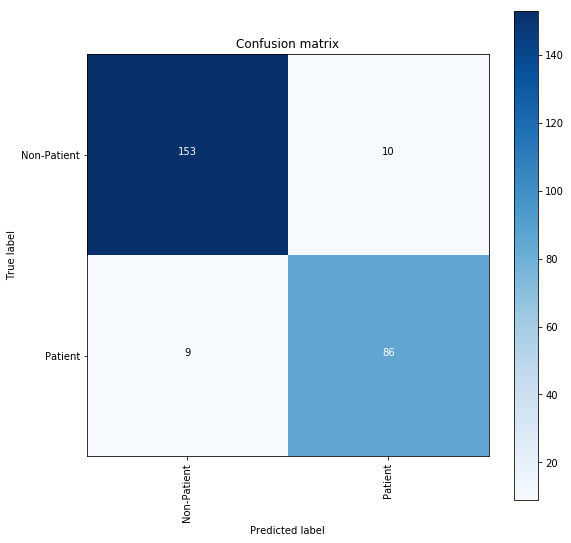

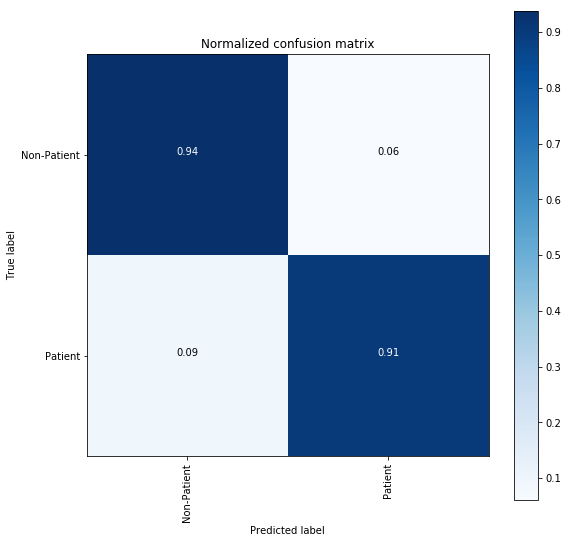

In [33]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# vis code borrowed from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, print_cm=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if print_cm:
        if normalize:
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig_size = (9,9)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

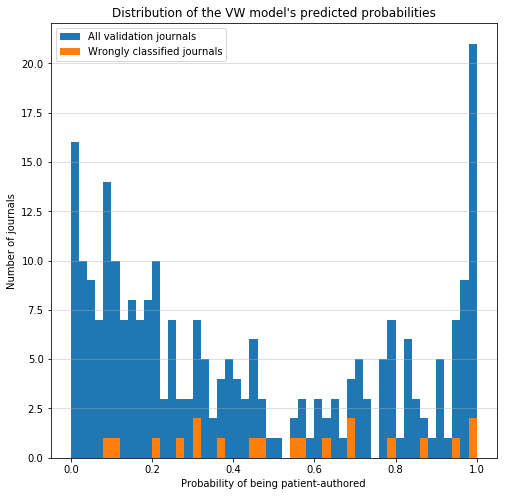

In [34]:
# Plot the distribution of 
title = "Distribution of the VW model's predicted probabilities"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = np.array(valid_df['prob'], dtype=float)
patches = plt.hist(x, bins=50, range=(0,1), label="All validation journals")

# Plot the distribution of specifically the wrongly-classified journal entries
x2 = np.array(valid_df[valid_df["is_patient"] != valid_df["is_patient_predicted"]]['prob'], dtype=float)
plt.hist(x2, bins=50, range=(0,1), label="Wrongly classified journals")
ax.set_title(title)
ax.set_xlabel("Probability of being patient-authored")
ax.set_ylabel("Number of journals")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [35]:
# Within the errors, show the least-confident journal posts
errors = valid_df[valid_df["is_patient"] != valid_df["is_patient_predicted"]]
inds = np.argsort(np.abs(errors['prob'] - 0.5))

# Show the n least-confident results that were wrongly classified
n = 10
toughest_n = errors.iloc[inds[:n]]

HTML(toughest_n.to_html(escape=False))

,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data,annotation_url
1053,901652,53ed62344db9219d247b4cab,-0.133032,0.466791,True,False,False,http://127.0.0.1:5000/siteId/901652#53ed62344db9219d247b4cab
1098,832212,523bdf604db921b54b0a1535,0.174669,0.543557,False,True,False,http://127.0.0.1:5000/siteId/832212#523bdf604db921b54b0a1535
1201,1007247,552d8d378b5cd3f41c21e53f,-0.20994,0.447707,True,False,False,http://127.0.0.1:5000/siteId/1007247#552d8d378b5cd3f41c21e53f
1207,832080,55a69c4ba689b41341e02d8c,0.25218,0.562713,False,True,False,http://127.0.0.1:5000/siteId/832080#55a69c4ba689b41341e02d8c
1077,858245,53063f55ac7ee9ea34cd9dc4,-0.518233,0.373266,True,False,False,http://127.0.0.1:5000/siteId/858245#53063f55ac7ee9ea34cd9dc4
1156,823361,522be9294db921002b025d0e,0.526603,0.62869,False,True,False,http://127.0.0.1:5000/siteId/823361#522be9294db921002b025d0e
1232,1085583,56e24d52af3d79ae43aa439d,0.76357,0.682128,False,True,False,http://127.0.0.1:5000/siteId/1085583#56e24d52af3d79ae43aa439d
1284,833473,528ed8b6ac7ee9e16e88e8df,0.786968,0.68718,False,True,False,http://127.0.0.1:5000/siteId/833473#528ed8b6ac7ee9e16e88e8df
1197,975141,558b3ebcca16b4da52e4b21f,-0.811403,0.307592,True,False,False,http://127.0.0.1:5000/siteId/975141#558b3ebcca16b4da52e4b21f
1043,1024806,55b9e5928b5cd3935433cdcb,-0.824637,0.30478,True,False,False,http://127.0.0.1:5000/siteId/1024806#55b9e5928b5cd3935433cdcb


### Save the predictions of the model on the training/validation data

In [36]:
# insert predictions into annotation web client's database
def insert_author_predictions(predictions, commit=True):
    prediction_type = 'journal_author_type'
    try:
        db = get_annotation_db()
        
        for prediction in predictions:
            site_id = prediction['site_id']
            journal_oid = prediction['journal_oid']
            data = prediction['data']
            probability = prediction['probability']
        
            db.execute(
                """INSERT INTO journalPrediction 
                (site_id, journal_oid, prediction_type, data, probability) 
                VALUES (?, ?, ?, ?, ?)""",
                (site_id, journal_oid, prediction_type, data, probability)
            )
        
        
        if commit:
            db.commit()
    finally:
        db.close()

In [37]:
%%time
if not skip_prediction_insertion:
    predictions = [{'site_id': pred_df.iloc[i]['site_id'],
                    'journal_oid': pred_df.iloc[i]['journal_oid'],
                    'data': "Patient" if pred_df.iloc[i]['is_patient_predicted'] else "Non-patient",
                    'probability': pred_df.iloc[i]['prob']}
                   for i in range(len(pred_df))]
    predictions[0]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [38]:
if not skip_prediction_insertion:
    insert_author_predictions(predictions)

### Apply the model to unlabeled data

First, we'll create a file in VW format from a set of unlabeled sites.

Then, we'll apply the model to the file to get predictions.

Finally, we'll load in the predictions and analyze the highest and lowest confidence journals to see if there are clear error patterns or if there is a clear bias in the model.

In [39]:
candidate_site_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
valid_sites_filename = os.path.join(candidate_site_working_dir, "valid_classification_sites.txt")

In [40]:
with open(valid_sites_filename, 'r') as infile:
    candidate_site_ids = [int(line.strip()) for line in infile]
len(candidate_site_ids)

58465

In [41]:
# randomly select a subset of n sites to predict the labels for
random.shuffle(candidate_site_ids)

n = 1000
candidate_subset = candidate_site_ids[:n]

candidate_subset[:5]

[907101, 431442, 138286, 427256, 112639]

#### Format the selected sites in VW format

In [42]:
unlabeled_vw_test_filepath = os.path.join(vw_working_dir, "unlabeled_candidate_sites.txt")

# only create the file if it doesn't exist
lines_written = 0
if not os.path.exists(unlabeled_vw_test_filepath):
    with open(unlabeled_vw_test_filepath, 'w', encoding="utf-8") as outfile:
        for site_id in tqdm(candidate_subset):
            body_list = get_journal_texts(site_id)
            for body in body_list:
                journal_oid = body['journal_oid']
                body_text = body['body']
                if len(body_text) < 50:
                    continue
                cleaned_body = get_cleaned_text(body_text)

                identifier = "sid%djoid%s" % (site_id, journal_oid)
                formatted_journal = identifier + "|J " + cleaned_body

                outfile.write(formatted_journal + "\n")
                lines_written += 1

lines_written

0

In [43]:
!head -n 1 {unlabeled_vw_test_filepath}

sid104744joid51be13876ca0045c3300ba02|J the first day of the new year ! clint , kylie , & jordan are putting away the christmas lights on the house , and kamryn is napping . i have some quiet time right now ! 2009 is going to be a great year - we are very optimistic that my cancer is going to be short lived and we will be back to our normal , busy lives soon .


#### Apply the VW model to the file

In [44]:
%%bash -s {vw_working_dir} {unlabeled_vw_test_filepath}
working_dir=${1}
unlabeled_vw_test_filepath=${2}

echo "Making predictions on test file."
vw --binary \
   -t -i ${working_dir}/patient_authored.model \
   -p ${working_dir}/unlabeled_text_only.pred \
   -r ${working_dir}/unlabeled_text_only.pred.raw \
   -d ${unlabeled_vw_test_filepath}
 
echo "Finished."

Making predictions on test file.
Finished.


Generating 3-grams for all namespaces.
only testing
predictions = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/unlabeled_text_only.pred
raw predictions = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/unlabeled_text_only.pred.raw
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/unlabeled_candidate_sites.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      214
    n.a.     n.a.            2            2.0  unknown  -1.0000     1000
    n.a.     n.a.            4            4.0  unknown  -1.0000      709
    n.a.     n.a.            8            8.0  unknown  -1.0000

In [45]:
raw_predictions_filepath = os.path.join(vw_working_dir, "unlabeled_text_only.pred.raw")
assert os.path.exists(raw_predictions_filepath)

In [46]:
!head {raw_predictions_filepath}

0.010806 sid104744joid51be13876ca0045c3300ba02
-5.685698 sid104723joid51be13876ca0045c3300bc8c
0.465668 sid104744joid51be13876ca0045c3300bc58
-4.489876 sid104723joid51be13876ca0045c3300bc92
2.842346 sid104744joid51be13876ca0045c3300be44
1.040100 sid104744joid51be13876ca0045c3300be7e
-0.565095 sid104745joid51be13876ca0045c3300ba7a
-1.910431 sid104748joid51be13876ca0045c3300bc7e
0.129856 sid104744joid51be13876ca0045c3300bed8
-6.740276 sid104723joid51be13876ca0045c3300bce4


#### Load the predictions into Python

In [47]:
def get_author_predictions(raw_predictions_filepath):
    
    with open(raw_predictions_filepath, 'r') as infile:
        pred_lines = infile.readlines()
    
    dtype_dict = {"site_id": int, 
                     "journal_oid": str,
                     "prob": float,
                     "is_patient": bool}
    columns = list(dtype_dict.keys())
    dtype = [dtype_dict[col] for col in columns]
    pred_df = pd.DataFrame(index=range(len(pred_lines)), columns=columns)
    
    site_id_list = []
    journal_oid_list = []
    prob_list = []
    is_patient_list = []
    url_list = []
    index = 0
    for pred_line in tqdm(pred_lines):
        raw_prob, journal_id = pred_line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        
        # probability is computed assuming a logistic loss function
        # if we change the model to use a different loss, this won't work anymore!
        prob = 1 / (1 + np.exp(-1 * float(raw_prob) ))
        assert prob >= 0 and prob <= 1
        is_patient = prob >= 0.5
        
        url = get_url(site_id, journal_oid)
        
        site_id_list.append(site_id)
        journal_oid_list.append(journal_oid)
        prob_list.append(prob)
        is_patient_list.append(is_patient)
        url_list.append(url)
        
        #pred_df.iloc[index]["site_id"] = site_id
        #pred_df.iloc[index]["journal_oid"] = journal_oid
        #pred_df.iloc[index]["is_patient"] = is_patient
        #pred_df.iloc[index]["raw_prob"] = float(raw_prob)
        #pred_df.iloc[index]["prob"] = prob
        
        index += 1
    
    pred_df['site_id'] = site_id_list
    pred_df['journal_oid'] = journal_oid_list
    pred_df['prob'] = prob_list
    pred_df['is_patient'] = is_patient_list
    pred_df['annotation_url'] = url_list
    return pred_df

In [48]:
%%time
unlabeled_df = get_author_predictions(raw_predictions_filepath)
len(unlabeled_df)

100%|██████████| 3055988/3055988 [00:29<00:00, 104129.49it/s]


CPU times: user 32.4 s, sys: 1.79 s, total: 34.2 s
Wall time: 34.2 s


In [49]:
unlabeled_df.head()

,site_id,journal_oid,prob,is_patient,annotation_url
0,104744,51be13876ca0045c3300ba02,0.502701,True,"<a href=""http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300ba02"">http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300ba02</a>"
1,104723,51be13876ca0045c3300bc8c,0.003383,False,"<a href=""http://127.0.0.1:5000/siteId/104723#51be13876ca0045c3300bc8c"">http://127.0.0.1:5000/siteId/104723#51be13876ca0045c3300bc8c</a>"
2,104744,51be13876ca0045c3300bc58,0.614358,True,"<a href=""http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300bc58"">http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300bc58</a>"
3,104723,51be13876ca0045c3300bc92,0.011097,False,"<a href=""http://127.0.0.1:5000/siteId/104723#51be13876ca0045c3300bc92"">http://127.0.0.1:5000/siteId/104723#51be13876ca0045c3300bc92</a>"
4,104744,51be13876ca0045c3300be44,0.944922,True,"<a href=""http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300be44"">http://127.0.0.1:5000/siteId/104744#51be13876ca0045c3300be44</a>"


#### Write the assigned predictions to the annotation database

In [50]:
%%time
# we have to do some tedious nonsense here to avoid dealing with how slow pandas indexing is
if not skip_prediction_insertion:
    site_id_list = unlabeled_df['site_id'].tolist()
    journal_oid_list = unlabeled_df['journal_oid'].tolist()
    prob_list = unlabeled_df['prob'].tolist()
    is_patient_list = unlabeled_df['is_patient'].tolist()
    predictions = [{'site_id': site_id, 
                    'journal_oid': journal_oid,
                    'data': "Patient" if is_patient else "Non-patient",
                    'probability': prob} 
                   for site_id, journal_oid, is_patient, prob
                   in zip(site_id_list, journal_oid_list, is_patient_list, prob_list)]
    del site_id_list, journal_oid_list, is_patient_list, prob_list
    predictions[0], len(predictions)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [51]:
%%time
if not skip_prediction_insertion:
    insert_author_predictions(predictions)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [52]:
# these are redundant with the df, and may take up quite a lot of memory, so delete them
if not skip_prediction_insertion:
    del predictions

#### Analyze the predictions produced by the model on the unlabeled sites

We look at the general distribution of the probabilities and look at the journals about which the classifier is least certain.

We then look at the distribution of patient posts within a site.

In [53]:
Counter(unlabeled_df['is_patient']).most_common()

[(False, 1795892), (True, 1260096)]

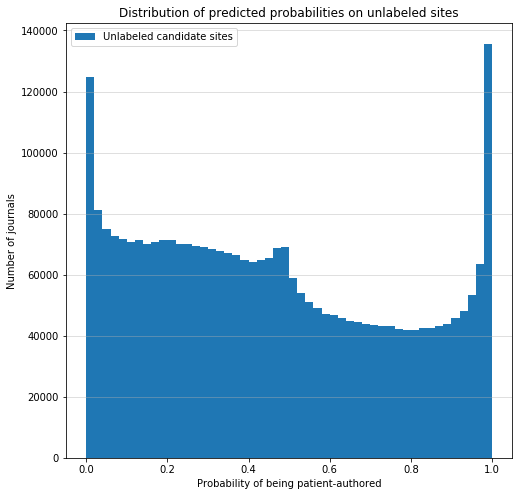

In [54]:
# Plot the distribution of unlabeled journal predicted probabilities
title = "Distribution of predicted probabilities on unlabeled sites"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = np.array(unlabeled_df['prob'], dtype=float)
patches = plt.hist(x, bins=50, range=(0,1), label="Unlabeled candidate sites")

ax.set_title(title)
ax.set_xlabel("Probability of being patient-authored")
ax.set_ylabel("Number of journals")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [55]:
# Within the errors, compute the least-confident journal posts (those with probability closest to 0.5)
inds = np.argsort(np.abs(unlabeled_df['prob'] - 0.5))

In [56]:
# Show the n least-confident results in a dataframe
n = 16
toughest_n = unlabeled_df.iloc[inds[:n]]

HTML(toughest_n.to_html(escape=False))

,site_id,journal_oid,prob,is_patient,annotation_url
1100408,190877,51be29e96ca004487a007bd0,0.500000,True,http://127.0.0.1:5000/siteId/190877#51be29e96ca004487a007bd0
896765,180789,51bf38686ca004e77811587c,0.500000,True,http://127.0.0.1:5000/siteId/180789#51bf38686ca004e77811587c
1514884,211597,51be2f106ca004200c01278c,0.500000,True,http://127.0.0.1:5000/siteId/211597#51be2f106ca004200c01278c
2809056,907882,544446e14db921cd51426502,0.500000,False,http://127.0.0.1:5000/siteId/907882#544446e14db921cd51426502
1286027,200024,51be2c296ca004a90200a919,0.500001,True,http://127.0.0.1:5000/siteId/200024#51be2c296ca004a90200a919
2303548,573549,51be5b866ca0045e21003353,0.499999,False,http://127.0.0.1:5000/siteId/573549#51be5b866ca0045e21003353
2513351,623145,51be87136ca0040e28001748,0.500001,True,http://127.0.0.1:5000/siteId/623145#51be87136ca0040e28001748
843965,176398,51be26bf6ca004007000e751,0.499998,False,http://127.0.0.1:5000/siteId/176398#51be26bf6ca004007000e751
848549,176398,51bf38736ca004e77811eb48,0.499998,False,http://127.0.0.1:5000/siteId/176398#51bf38736ca004e77811eb48
2842933,910321,54cae85bab28b9e44fb994e3,0.499998,False,http://127.0.0.1:5000/siteId/910321#54cae85bab28b9e44fb994e3


In [57]:
patient_proportions_dict = {}
total_patient_journals = 0
for site_id, group in unlabeled_df.groupby(by="site_id"):
    patient_journals = np.count_nonzero(group['is_patient'])
    total_patient_journals += patient_journals
    
    num_journals = len(group)
    
    patient_proportion = patient_journals / num_journals
    patient_proportions_dict[site_id] = patient_proportion
print("Identified %d total journals as patient-authored." % total_patient_journals)
len(patient_proportions_dict)

Identified 1260096 total journals as patient-authored.


58462

In [69]:
# Write out the site proportions data to a CSV file
site_proportions_filepath = os.path.join(general_working_dir, "site_proportions.csv")
with open(site_proportions_filepath, 'w') as outfile:
    outfile.write("site_id,proportion_patient_authored\n")
    for site_id in patient_proportions_dict:
        proportion_patient_authored = patient_proportions_dict[site_id]
        outfile.write("{},{}\n".format(site_id, proportion_patient_authored))
print("Finished.")

Finished.


In [58]:
Counter(["Mostly patient" if p > 0.5 else "Mostly non-patient" for p in patient_proportions_dict.values()]).most_common()

[('Mostly non-patient', 34873), ('Mostly patient', 23589)]

In [59]:
# percent that are mostly patient-authored
np.sum([1 if p > 0.5 else 0 for p in patient_proportions_dict.values()]) / len(patient_proportions_dict)

0.40349286716157506

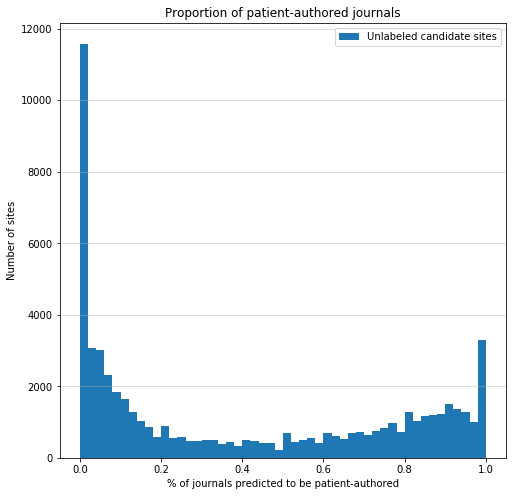

In [60]:
# Plot the distribution of unlabeled journal predicted probabilities
title = "Proportion of patient-authored journals"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = patient_proportions_dict.values()
patches = plt.hist(x, bins=50, range=(0,1), label="Unlabeled candidate sites")

ax.set_title(title)
ax.set_xlabel("% of journals predicted to be patient-authored")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [61]:
# look at the distribution over time (by bucketing by percentile journals complete on the site?)

def get_journal_metadata_db():
    db_filepath="/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features/journal_metadata.db"
    db = sqlite3.connect(
            db_filepath,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db

def get_journal_times(site_id):
    try:
        db = get_journal_metadata_db()
        cursor = db.execute("""SELECT journal_oid, site_index, created_at
                                    FROM journalMetadata
                                    WHERE site_id = ? 
                                    GROUP BY journal_oid
                                    ORDER BY id DESC""",
                                (site_id,))
        
        times = []
        results = cursor.fetchall()
        if results is None:
            return []
        for result in results:
            d = {key: result[key] for key in result.keys()}
            times.append(d)
        times.sort(key=lambda d: d['created_at'])
        
        journal_oid_dict = {}
        for time_dict in times:
            journal_oid_dict[time_dict['journal_oid']] = time_dict
        return journal_oid_dict
    finally:
        db.close()

buckets = 20
percentile_gap = 1 / buckets
print("%d buckets will each capture %.2f%% of a site's journals." % (buckets, percentile_gap * 100))

total_bucket_counts = [0 for i in range(buckets)]
is_patient_bucket_counts = [0 for i in range(buckets)]

for site_id, group in tqdm(unlabeled_df.groupby(by="site_id")):
    if len(group) < 20:
        continue  # only compute percentiles for sites with at least X journals
    
    journal_times = get_journal_times(site_id)
    num_journals = len(journal_times)
    assert num_journals >= len(group)
    
    journal_oid_list = group['journal_oid']
    is_patient_list = group['is_patient'].tolist()
    
    for i, journal_oid in enumerate(journal_oid_list):
        site_index = journal_times[journal_oid]['site_index']
        created_at = journal_times[journal_oid]['created_at']
        
        percent_through_site = site_index / num_journals
        assert percent_through_site < 1
        
        bucket_right_boundary = percentile_gap
        bucket = 0
        while percent_through_site > bucket_right_boundary:
            bucket += 1
            bucket_right_boundary += percentile_gap
        
        #print(site_index, percent_through_site, bucket)
        if bucket_right_boundary >= 1:  # should be in the last bucket
            bucket = buckets - 1
            
        total_bucket_counts[bucket] += 1
        if is_patient_list[i]:
            is_patient_bucket_counts[bucket] += 1
np.mean(total_bucket_counts), np.mean(is_patient_bucket_counts)

20 buckets will each capture 5.00% of a site's journals.


100%|██████████| 58462/58462 [02:33<00:00, 381.46it/s]


(141703.45, 58771.75)

In [62]:
is_patient_bucket_counts

[64512,
 56772,
 56908,
 59264,
 59222,
 57709,
 59203,
 57269,
 61142,
 56583,
 63835,
 62331,
 58639,
 60554,
 60884,
 58707,
 57769,
 58519,
 56602,
 49011]

In [63]:
bucket_proportions = [patient / total for patient, total in zip(is_patient_bucket_counts, total_bucket_counts)]
bucket_proportions

[0.39526747584415267,
 0.40064925899788284,
 0.4048950551405194,
 0.4097515107097916,
 0.4148186543014443,
 0.41601966593856554,
 0.4187745805392864,
 0.4208078299398206,
 0.4225665551654549,
 0.424762219336241,
 0.4229668305482302,
 0.4236860708556513,
 0.42322127112894614,
 0.4226063774103722,
 0.4204492876725573,
 0.4175462304409673,
 0.41688496316021156,
 0.41121081590061065,
 0.40604017216642757,
 0.4032001974414874]

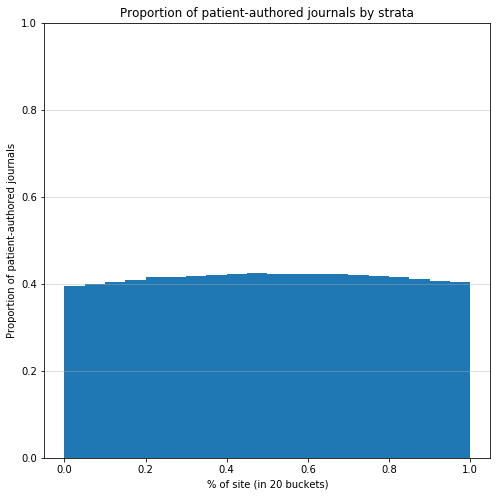

In [64]:
title = "Proportion of patient-authored journals by strata"
fig, ax = pl.subplots(num=title, figsize=(8,8))

x = np.arange(0, 1, percentile_gap)
y = bucket_proportions
plt.bar(x, y, percentile_gap, align='edge')

ax.set_title(title)
ax.set_xlabel("%% of site (in %d buckets)" % buckets)
ax.set_ylabel("Proportion of patient-authored journals")

#ax.set_xticks([i for i in range(0, 108, 4)])
#ax.set_xticklabels([str(i) if i != 104 else "+" for i in range(0, 108, 4)])

#ax.set_yticks([i for i in range(0, 430, 10)])

ax.set_ylim((0, 1))

ax.grid(axis="y", alpha=0.5)
plt.show()